In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 

import statsmodels

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 

df1_raw = X.assign(Target=y.get('Target'))

# making a copy to use 
df1 = df1_raw.copy(deep=True)

df1_raw.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# Training Model based on Previous Observations and Tests

## Data Cleaning and Preprocessing

Since we are predicting if the student is a drop-out or not, we will only need to divide them into two groups: dropout, and enrolled/graduate. Thus, 'Graduate' and 'Enrolled' in the original dataset are combined into one group 'Graduate/Enrolled'. In the resulting data frame, Target is a binary variable, which 0 indicates that the student is a drop-out, and 1 indicates that the student is a non drop-out.

In [3]:
# Combining 'Graduate' and 'Enrolled' into one 
def get_target(y):
    if (y == 'Graduate') or (y == 'Enrolled'):
        return 'Graduate/Enrolled'
    else:
        return 'Dropout'
        
df1['Target'] = df1.get('Target').apply(get_target)

df1['Target'] = df1['Target'].apply(lambda x: 0 if x == 'Dropout' else 1)

In [4]:
df1.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,1
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,1
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,1


### Determine Features, and process the Data Frame
Based on our Exploratory Data Analysis and Hypothesis Testing, we found out that comparing to students who are not dropping out, drop-out students have noticeable larger proportion in the following categories of 1) married or divorced, 2) not compeleting high school, 3) not displaced, 4)being debtors. Moreover, these students have obvious lower proportion in having a scholarship. Thus, among all the categorical columns in the dataset, the following 5 columns will be taking into account as our features for the **Baseline model**: Marital Status, Displaced, Previous Qualification (grade), Debtor, and Scholarship. 

In [5]:
#for our baseline model, we wll only have the 5 categorical features, and the target.
df_base = df1[['Marital Status','Displaced','Previous qualification (grade)',
               'Debtor','Scholarship holder','Target']]
df_base = pd.get_dummies(df_base, columns=['Marital Status'])
df_base.head()

,Displaced,Previous qualification (grade),Debtor,Scholarship holder,Target,Marital Status_1,Marital Status_2,Marital Status_3,Marital Status_4,Marital Status_5,Marital Status_6
0,1,122.0,0,0,0,1,0,0,0,0,0
1,1,160.0,0,0,1,1,0,0,0,0,0
2,1,122.0,0,0,0,1,0,0,0,0,0
3,1,122.0,0,0,1,1,0,0,0,0,0
4,0,100.0,0,0,1,0,1,0,0,0,0


### Split the dataset into Features and Target Variable

The dataset above is now prepared to conduct further training and is splitted into features and target variables based on the study from earlier sections. In order to prevent overfitting of the model, 20% of the data in the dataset is selected to be the test data, an the rest 80% will be the training data. 


In [6]:
# Split dataset into features and target variable
X_base = df_base.drop('Target', axis=1)
y_base = df_base['Target']

# Split data into training and test sets
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

# Feature scaling
scaler_base = StandardScaler()
X_train_base = scaler_base.fit_transform(X_train_base)
X_test_base = scaler_base.transform(X_test_base)


## Building Random Forest Classifier for Baseline Model
The final target classification is binary, with the choices of being drop-out or not. The classifer being used to build this model is **Random Forest Classifier**. In the following section, the classifier will be initialized and perform training process on the training data. 

In [7]:
from sklearn.metrics import confusion_matrix
# Initialize the model
model_base = RandomForestClassifier(random_state=42)

# Train the model
model_base.fit(X_train_base, y_train_base)

# Predict on the test data
y_pred_base = model_base.predict(X_test_base)

# Evaluate the model
baseline_accuracy = accuracy_score(y_test_base, y_pred_base)
print(f'Accuracy: {baseline_accuracy}')

#confusion matrix
confusion_matrix_base = confusion_matrix(y_test_base, y_pred_base)

confusion_matrix_base


Accuracy: 0.6983050847457627


array([[117, 199],
       [ 68, 501]])

The accuracy score for the baseline model is 0.69, meaning the model is able to predict 69% of test data. From the confusion matrix, we found out that 94 observations are true positive, and 519 are true negative. There is a relatively high Type 1 error rate. We will continue refining our model in the next section. 

## Adding Second Semester Grades into the Model

Calculating the mean second semester grade for both drop-out students and non drop-out students, we found out the mean is quite different. In the visualization below, it has shown that the second semester grade for drop-out students is much lower than those of non drop-out students. This implies that the second semester grade might have a greate effect on the accuracy of the prediction model. In the following updated model, Second Semester Grade will be added into the model, and this model now has 6 features. 

In [8]:
gr_dropout = (df1[df1['Target']==0]['Curricular units 2nd sem (grade)']).mean()
gr_non = (df1[df1['Target']==1]['Curricular units 2nd sem (grade)']).mean()
print(gr_dropout,gr_non)
#The second semester grade for dropout is 5.9/20, and is 12.3 for non-dropout. The dropout students have much lower grades.

5.899338850028149 12.279543660146519


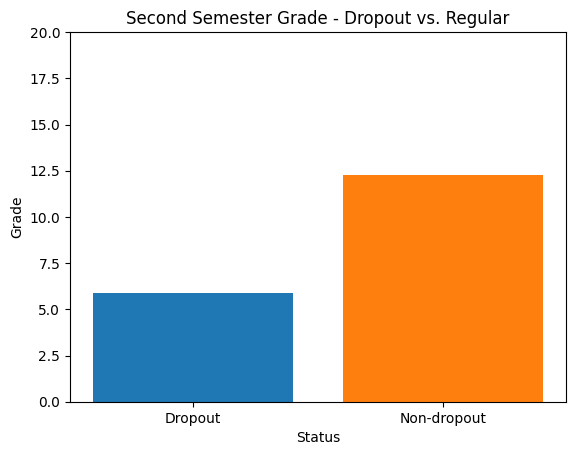

In [9]:
grades = [gr_dropout,gr_non]
labels = ['Dropout', 'Non-dropout']
title = 'Second Semester Grade - Dropout vs. Regular'
y_max = 20

# Creating the bar plot
plt.figure()
plt.bar(labels, grades, color=['#1f77b4', '#ff7f0e'])
plt.ylim(0, y_max)

# Adding titles and labels
plt.title(title)
plt.xlabel('Status')
plt.ylabel('Grade')
# Show plot
plt.show()

In [10]:
#adding new features into the model.
df_updated = df1[[
    'Curricular units 2nd sem (grade)',
    'Marital Status','Displaced',
    'Previous qualification (grade)',
    'Debtor',
    'Scholarship holder',
    'Target']]
df_updated = pd.get_dummies(df_updated, columns=['Marital Status'])
df_updated.head()

,Curricular units 2nd sem (grade),Displaced,Previous qualification (grade),Debtor,Scholarship holder,Target,Marital Status_1,Marital Status_2,Marital Status_3,Marital Status_4,Marital Status_5,Marital Status_6
0,0.000000,1,122.0,0,0,0,1,0,0,0,0,0
1,13.666667,1,160.0,0,0,1,1,0,0,0,0,0
2,0.000000,1,122.0,0,0,0,1,0,0,0,0,0
3,12.400000,1,122.0,0,0,1,1,0,0,0,0,0
4,13.000000,0,100.0,0,0,1,0,1,0,0,0,0


In [11]:
X_updated = df_updated.drop('Target', axis=1)
y_updated = df_updated['Target']

# Split data into training and test sets
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(X_updated, y_updated, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_updated = scaler.fit_transform(X_train_updated)
X_test_updated = scaler.transform(X_test_updated)

model_updated = RandomForestClassifier(random_state=42)

# Train the model
model_updated.fit(X_train_updated, y_train_updated)

# Predict on the test data
y_pred_updated = model_updated.predict(X_test_updated)

# Evaluate the model
final_accuracy = accuracy_score(y_test_updated, y_pred_updated)
print(f'Accuracy: {final_accuracy}')

confusion_matrix_updated = confusion_matrix(y_test_updated, y_pred_updated)

confusion_matrix_updated

Accuracy: 0.7785310734463277


array([[183, 133],
       [ 63, 506]])

After adding the second semester grade as one of the feature, the true positive observations have significantly increase, and the accuracy score is increased by around 8% comparing to the baseline model. The accuracy score is now 77.85%. This improvement has shown that the second semester grade does have prediction power in terms of deciding if a student is a drop-out. 

# Final Model

In the final model, addition to the 6 features we had in the updated model, two more features which are "Course" and "Tuition fees up to date" will be added. 

In the left visualization below, it is quite obvious that most of the enrolled/graduate students have tuition fees up to date. However, by looking at the second graph for the drop out students, 32% of drop-out students do not pay off all the tuition fees. 

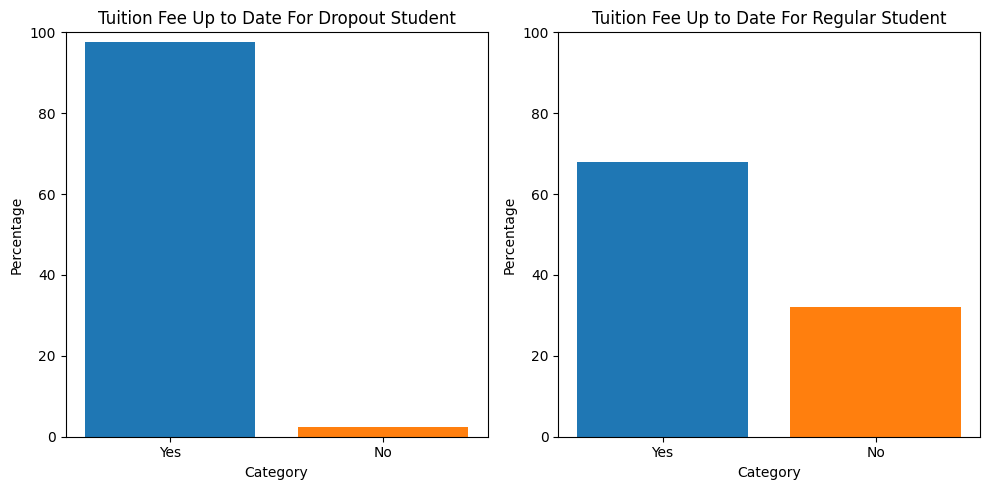

In [12]:
# Data for plotting - first graph
categories = ['Yes', 'No']
values_target_0 = ((df1[df1['Target']==1]['Tuition fees up to date'].value_counts(normalize=True)).values)*100

# Data for plotting - second graph
values_target_1 = ((df1[df1['Target']==0]['Tuition fees up to date'].value_counts(normalize=True)).values)*100

# Creating the subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# First bar plot
axes[0].bar(categories, values_target_0, color=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Tuition Fee Up to Date For Dropout Student')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Percentage')
axes[0].set_ylim(0, 100)

# Second bar plot
axes[1].bar(categories, values_target_1, color=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Tuition Fee Up to Date For Regular Student')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Percentage')
axes[1].set_ylim(0, 100)

# Display the bar plots
plt.tight_layout()
plt.show()

Moreover, connecting back to the hypothesis testing from earlier, there are sufficient evidences supporting that a larger proportion of dropout students were enrolled in Equinculture, Informatics Engineering, and Management (evening attendance). To have a better understanding on the proportions, the visualization below has shown that 50.7% of the students in the Management (evening attendance) course dropped out at the end. 

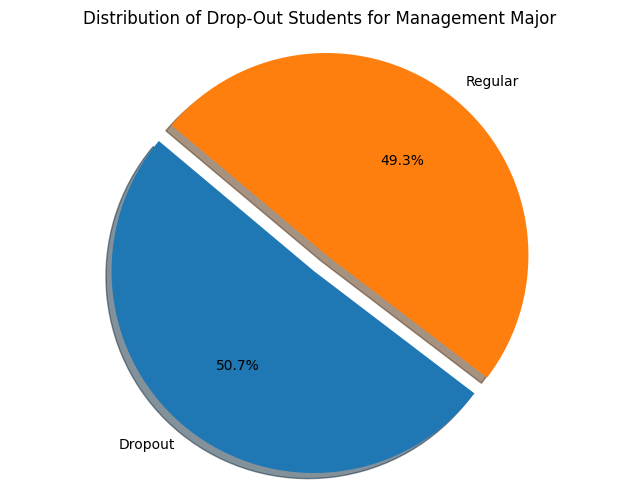

In [13]:
#non drop-out
df1[df1['Target']==1]['Course'].value_counts(normalize=True)
df1[df1['Course']==9991]['Target'].value_counts(normalize=True)

import matplotlib.pyplot as plt

# Data to plot
labels = 'Dropout', 'Regular'
sizes = (df1[df1['Course']==9991]['Target'].value_counts()).values  # Values are percentages of the 'Target' column
color=['#1f77b4', '#ff7f0e']
explode = (0.1, 0)  # explode the 1st slice (Non-Dropout)

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=color, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Drop-Out Students for Management Major')
plt.show()

With these analysis, we believe "course" and "Tuition fees up to date" may improve the prediction accuracy of the model.

In [14]:
#grades, 
df_final = df1[[
    'Course',
    'Tuition fees up to date',
    'Curricular units 2nd sem (grade)',
    'Marital Status','Displaced',
    'Previous qualification (grade)',
    'Debtor',
    'Scholarship holder',
    'Target']]
df_final = pd.get_dummies(df_final,columns=['Marital Status'])
df_final = pd.get_dummies(df_final,columns=['Course'])
df_final.head()

,Tuition fees up to date,Curricular units 2nd sem (grade),Displaced,Previous qualification (grade),Debtor,Scholarship holder,Target,Marital Status_1,Marital Status_2,Marital Status_3,...,Course_9130,Course_9147,Course_9238,Course_9254,Course_9500,Course_9556,Course_9670,Course_9773,Course_9853,Course_9991
0,1,0.000000,1,122.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,13.666667,1,160.0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0.000000,1,122.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,12.400000,1,122.0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,13.000000,0,100.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
X_final = df_final.drop('Target', axis=1)
y_final = df_final['Target']

# Split data into training and test sets
X_train_gr, X_test_gr, y_train_gr, y_test_gr = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_gr = scaler.fit_transform(X_train_gr)
X_test_gr = scaler.transform(X_test_gr)

In [16]:
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train_gr, y_train_gr)

# Predict on the test data
y_pred_gr = model.predict(X_test_gr)

# Evaluate the model
final_accuracy = accuracy_score(y_test_gr, y_pred_gr)
print(f'Accuracy: {final_accuracy}')

Accuracy: 0.8124293785310734


This concludes our model accuracy to 81.24%, which is a relatively high accuracy. In this section, through enhacing the prediction model, we found out that "Course", "Tuition fees up to date", "Curricular units 2nd sem (grade)", "Marital Status", "Displaced", "Previous qualification (grade)", "Debtor", and "Scholarship holder" have prediction powers in deciding if a student is a drop-out.